<a href="https://colab.research.google.com/github/inoue0426/scRNA-Data-Simulation-Comparison/blob/main/notebooks/zinbwave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# BiocManager::install("zinbwave")
BiocManager::install("scRNAseq")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.3 (2022-03-10)

Installing package(s) 'scRNAseq'

Old packages: 'crayon', 'fansi', 'gert', 'knitr', 'magrittr', 'processx',
  'RColorBrewer', 'readxl', 'rprojroot', 'sass', 'testthat', 'tinytex', 'tzdb',
  'vctrs', 'cluster', 'MASS', 'Matrix', 'mgcv', 'nlme'



In [7]:
library(zinbwave)
library(scRNAseq)
library(matrixStats)
library(magrittr)
library(ggplot2)
library(biomaRt)

# Register BiocParallel Serial Execution
BiocParallel::register(BiocParallel::SerialParam())


Attaching package: 'biomaRt'


The following object is masked from 'package:scRNAseq':

    listDatasets




In [8]:
fluidigm <- ReprocessedFluidigmData(assays = "tophat_counts")
fluidigm

snapshotDate(): 2021-10-19

see ?scRNAseq and browseVignettes('scRNAseq') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?scRNAseq and browseVignettes('scRNAseq') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?scRNAseq and browseVignettes('scRNAseq') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache



class: SingleCellExperiment 
dim: 26255 130 
metadata(3): sample_info clusters which_qc
assays(1): tophat_counts
rownames(26255): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(130): SRR1275356 SRR1274090 ... SRR1275366 SRR1275261
colData names(28): NREADS NALIGNED ... Cluster1 Cluster2
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [11]:
filter <- rowSums(assay(fluidigm)>5)>5
table(filter)

filter
FALSE  TRUE 
16127 10128 

In [12]:
fluidigm <- fluidigm[filter,]

In [13]:
assay(fluidigm) %>% log1p %>% rowVars -> vars
names(vars) <- rownames(fluidigm)
vars <- sort(vars, decreasing = TRUE)
head(vars)

IGFBPL1    STMN2     EGR1   ANP32E    CENPF     LDHA 
13.06109 12.24748 11.90608 11.67819 10.83797 10.72307

In [14]:
fluidigm <- fluidigm[names(vars)[1:100],]

In [15]:
assayNames(fluidigm)[1] <- "counts"

In [16]:
fluidigm_zinb <- zinbwave(fluidigm, K = 2, epsilon=1000)

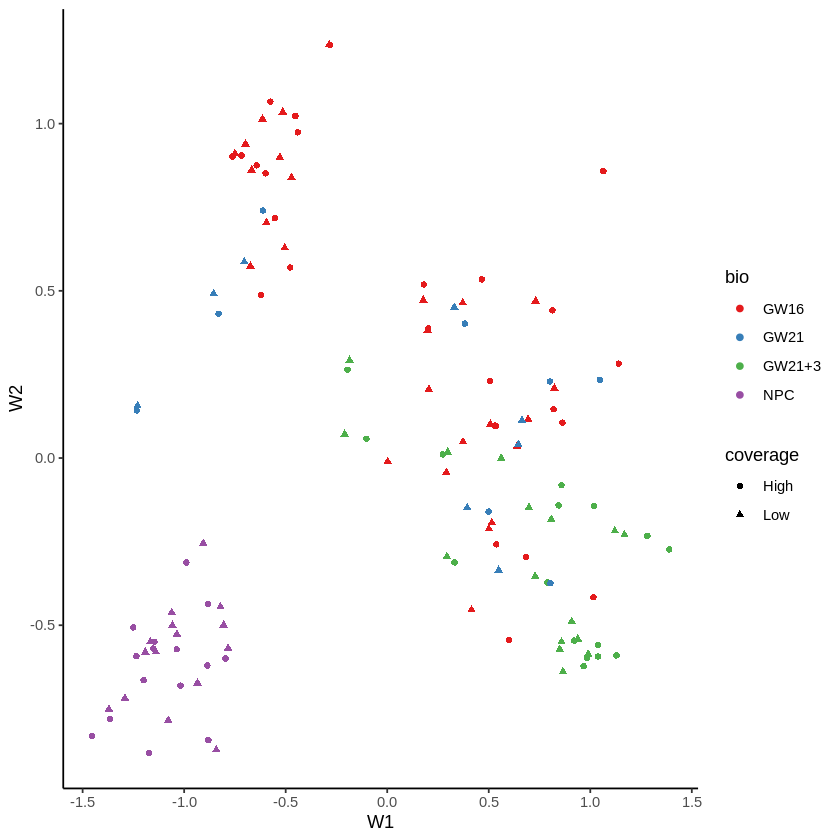

In [17]:
W <- reducedDim(fluidigm_zinb)

data.frame(
  W, bio=colData(fluidigm)$Biological_Condition,
  coverage=colData(fluidigm)$Coverage_Type) %>%
    ggplot(aes(W1, W2, colour=bio, shape=coverage)) + geom_point() + 
    scale_color_brewer(type = "qual", palette = "Set1") + theme_classic()

In [18]:
fluidigm_cov <- zinbwave(fluidigm, K=2, X="~Coverage_Type", epsilon=1000)

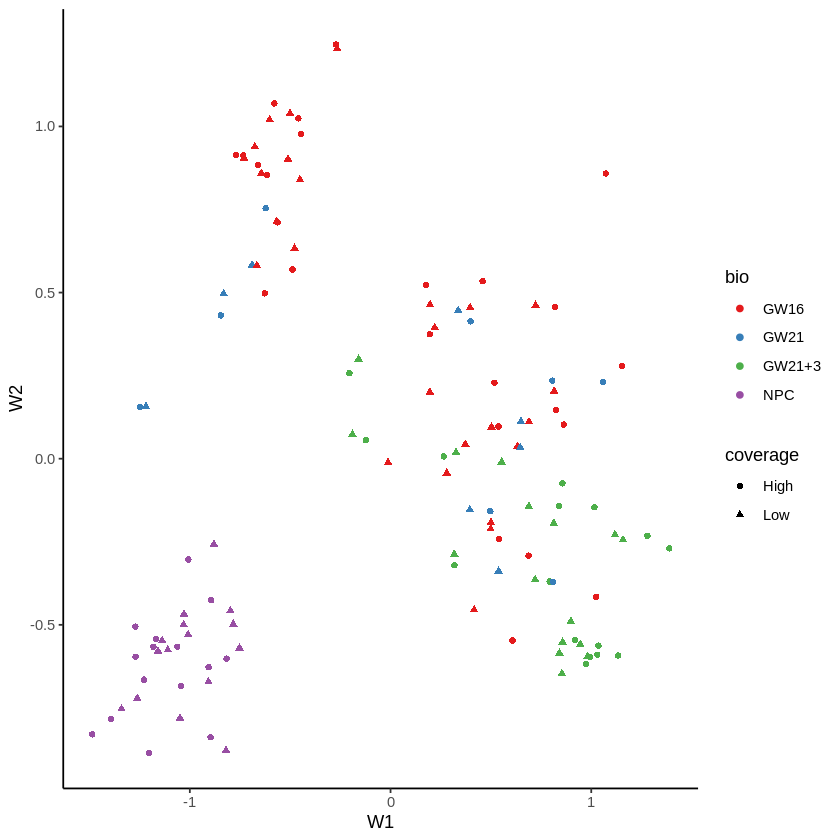

In [19]:
W <- reducedDim(fluidigm_cov)

data.frame(W, bio=colData(fluidigm)$Biological_Condition,
           coverage=colData(fluidigm)$Coverage_Type) %>%
    ggplot(aes(W1, W2, colour=bio, shape=coverage)) + geom_point() + 
    scale_color_brewer(type = "qual", palette = "Set1") + theme_classic()

In [22]:
mart <- useMart("ensembl")
mart <- useDataset("hsapiens_gene_ensembl", mart = mart)
bm <- getBM(attributes=c('hgnc_symbol', 'start_position',
                         'end_position', 'percentage_gene_gc_content'),
            filters = 'hgnc_symbol',
            values = rownames(fluidigm),
            mart = mart)

bm$length <- bm$end_position - bm$start_position
len <- tapply(bm$length, bm$hgnc_symbol, mean)
len <- len[rownames(fluidigm)]
gcc <- tapply(bm$percentage_gene_gc_content, bm$hgnc_symbol, mean)
gcc <- gcc[rownames(fluidigm)]